In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd # read the csv
import numpy as np
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
import tensorflow.keras.backend as K

In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

###1. Dataset Collection

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Data/train.csv')

In [5]:
df.head(10)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [6]:
df.head(10)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


###2. Data Cleaning

####2.1  Remove Special Characters, Punctuation, and Emojis



*   In the tweet column, you have a lot of special characters (e.g., !!!, !!!!!!, !!!!!! RT @UrKindOfBrand), which are not useful for text analysis.
*   You can remove or replace the special characters, and emojis.




In [7]:
import re

# Function to remove special characters, URLs, and emojis
def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove leading/trailing whitespace
    text = text.strip()
    return text

df['tweet'] = df['tweet'].apply(clean_text)


In [8]:
df['tweet'].head(10)

,tweet
0,RT mayasolovely As a woman you shouldnt compla...
1,RT mleew17 boy dats coldtyga dwn bad for cuffi...
2,RT UrKindOfBrand Dawg RT 80sbaby4life You ever...
3,RT CGAnderson vivabased she look like a tranny
4,RT ShenikaRoberts The shit you hear about me m...
5,TMadisonx The shit just blows meclaim you so f...
6,BrighterDays I can not just sit up and HATE on...
7,8220selfiequeenbri cause Im tired of you big b...
8,amp you might not get ya bitch back amp thats ...
9,rhythmixx hobbies include fighting Mariam bitch


####2.2 Remove Stop Words



*   Stop words (like "the", "a", "and") don’t contribute to the meaning of the text and can be removed.

*   Use a library like NLTK or spaCy to filter out stop words.



In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return " ".join(filtered_text)

df['tweet'] = df['tweet'].apply(remove_stopwords)


In [10]:
df['tweet'].head(10)

,tweet
0,RT mayasolovely woman shouldnt complain cleani...
1,RT mleew17 boy dats coldtyga dwn bad cuffin da...
2,RT UrKindOfBrand Dawg RT 80sbaby4life ever fuc...
3,RT CGAnderson vivabased look like tranny
4,RT ShenikaRoberts shit hear might true might f...
5,TMadisonx shit blows meclaim faithful somebody...
6,BrighterDays sit HATE another bitch got much s...
7,8220selfiequeenbri cause Im tired big bitches ...
8,amp might get ya bitch back amp thats
9,rhythmixx hobbies include fighting Mariam bitch


####2.3. Normalization: Lowercasing




*   It's important to convert all the text to lowercase so that words like “Apple” and “apple” are treated as the same.




In [11]:
df['tweet'] = df['tweet'].str.lower()
df['tweet'].head(10)

,tweet
0,rt mayasolovely woman shouldnt complain cleani...
1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,rt cganderson vivabased look like tranny
4,rt shenikaroberts shit hear might true might f...
5,tmadisonx shit blows meclaim faithful somebody...
6,brighterdays sit hate another bitch got much s...
7,8220selfiequeenbri cause im tired big bitches ...
8,amp might get ya bitch back amp thats
9,rhythmixx hobbies include fighting mariam bitch


####2.4. Stemming/Lemmatization



*   Stemming reduces words to their root form (e.g., "running" → "run").
* Lemmatization reduces words to their base form (e.g., "better" → "good")




In [12]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    return " ".join(lemmatized_text)

df['tweet'] = df['tweet'].apply(lemmatize_text)
df['tweet'].head(10)

,tweet
0,rt mayasolovely woman shouldnt complain cleani...
1,rt mleew17 boy dat coldtyga dwn bad cuffin dat...
2,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,rt cganderson vivabased look like tranny
4,rt shenikaroberts shit hear might true might f...
5,tmadisonx shit blow meclaim faithful somebody ...
6,brighterdays sit hate another bitch got much s...
7,8220selfiequeenbri cause im tired big bitch co...
8,amp might get ya bitch back amp thats
9,rhythmixx hobby include fighting mariam bitch


####2.5. Handle URLs



*   URLs can be removed or replaced with a placeholder like "URL". If URLs are important for context (e.g., sentiment analysis), you may decide to keep them.



In [13]:
df['tweet'] = df['tweet'].str.replace(r'http\S+', '', regex=True)
df['tweet'].head(10)

,tweet
0,rt mayasolovely woman shouldnt complain cleani...
1,rt mleew17 boy dat coldtyga dwn bad cuffin dat...
2,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,rt cganderson vivabased look like tranny
4,rt shenikaroberts shit hear might true might f...
5,tmadisonx shit blow meclaim faithful somebody ...
6,brighterdays sit hate another bitch got much s...
7,8220selfiequeenbri cause im tired big bitch co...
8,amp might get ya bitch back amp thats
9,rhythmixx hobby include fighting mariam bitch


####2.6. Check for Empty/Null Tweets



*   Sometimes after cleaning, some tweets may become empty or too short to be useful. Check for those and decide whether to remove or handle them.



In [14]:
df = df[df['tweet'].str.strip().notna()]


In [15]:
df.isnull().sum()


,0
count,0
hate_speech_count,0
offensive_language_count,0
neither_count,0
class,0
tweet,0


####3. EDA

####3.1. Distribution of tweet counts per classification category (hate speech, offensive language, neither).

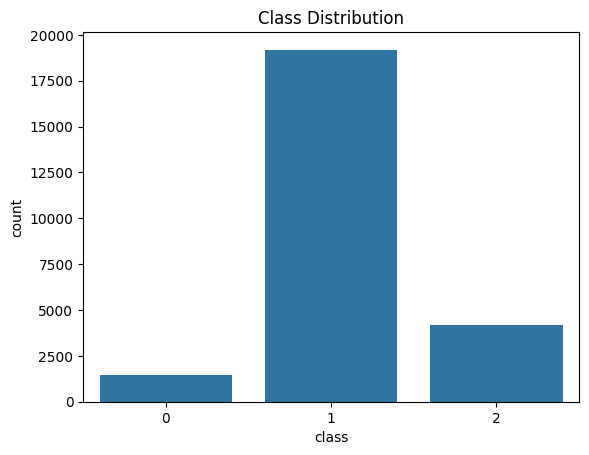

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of each class
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()


####3.2. Most common words/phrases associated with each class.

You'll want to filter the dataset based on the class column, which seems to indicate the type of tweet (hate speech, offensive language, neither). For simplicity, I'll assume class is categorical (0 = hate speech, 1 = offensive language, 2 = neither).

In [17]:
# Filter tweets by class
hate_speech_tweets = df[df['class'] == 0]['tweet']
offensive_language_tweets = df[df['class'] == 1]['tweet']
neither_tweets = df[df['class'] == 2]['tweet']


Tokenize (split the text into words).

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string



# Apply the preprocessing function
hate_speech_tokens = hate_speech_tweets.apply(word_tokenize)
offensive_language_tokens = offensive_language_tweets.apply(word_tokenize)
neither_tokens = neither_tweets.apply(word_tokenize)


You can use CountVectorizer from sklearn to get the most common words in each class. Alternatively, if you prefer, you can do it manually using Python's collections.Counter.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Function to get the most common words for a given set of tweets
def get_most_common_words(tweets, top_n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(tweets)
    word_freq = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame for easy visualization
    word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=['word', 'frequency'])
    return word_freq_df.sort_values(by='frequency', ascending=False)

# Get top 10 most common words for each class
hate_speech_top_words = get_most_common_words(hate_speech_tweets)
offensive_language_top_words = get_most_common_words(offensive_language_tweets)
neither_top_words = get_most_common_words(neither_tweets)






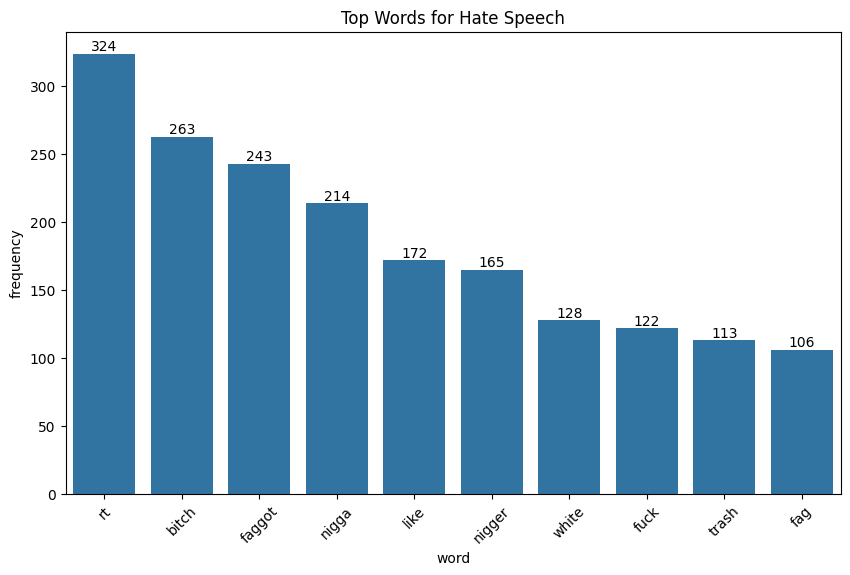

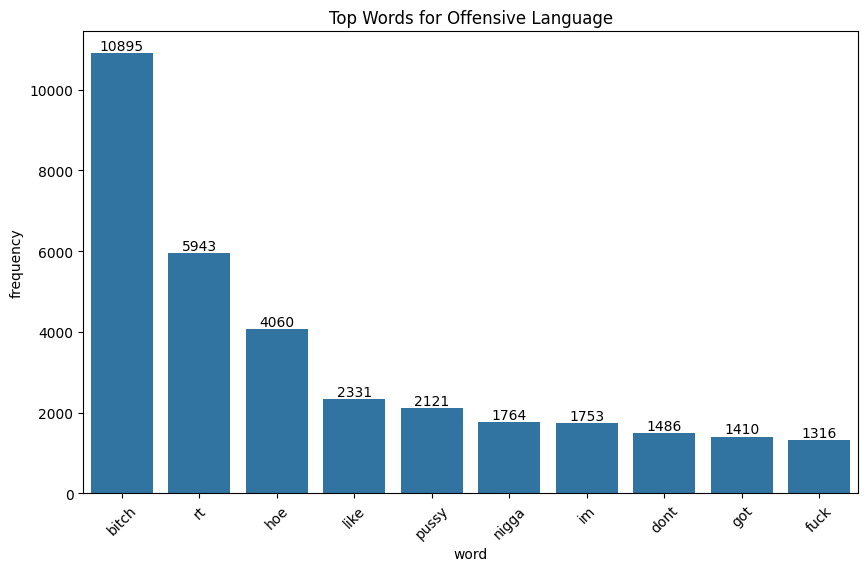

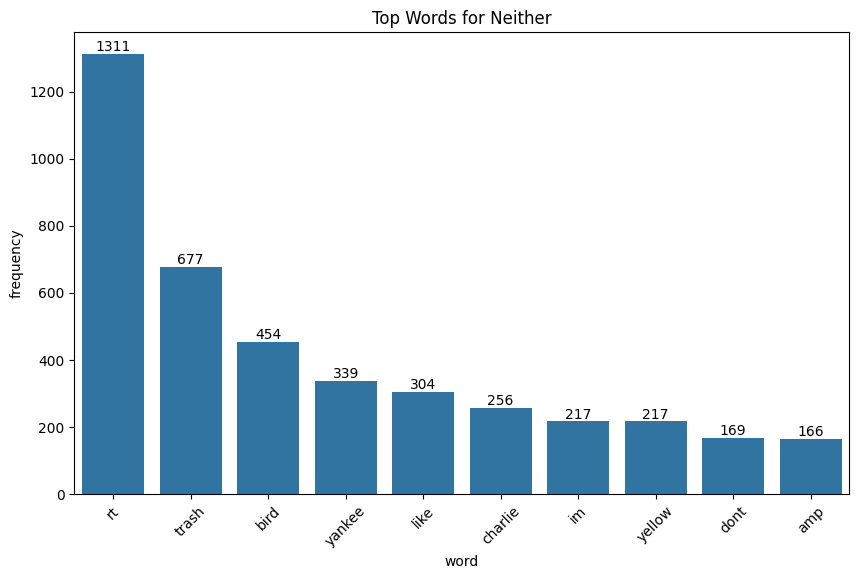

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot word frequency with labels on each bar
def plot_word_frequency(word_freq_df, title):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='word', y='frequency', data=word_freq_df)

    # Add frequency on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot top words for each class
plot_word_frequency(hate_speech_top_words, 'Top Words for Hate Speech')
plot_word_frequency(offensive_language_top_words, 'Top Words for Offensive Language')
plot_word_frequency(neither_top_words, 'Top Words for Neither')


Visualizing frequancy through word cloud

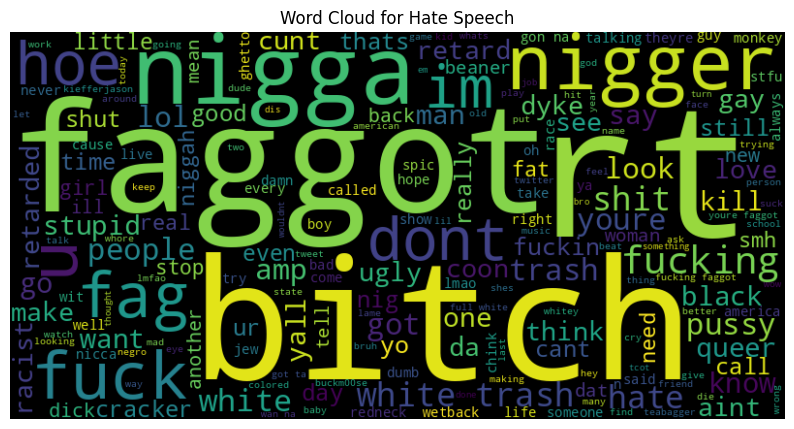

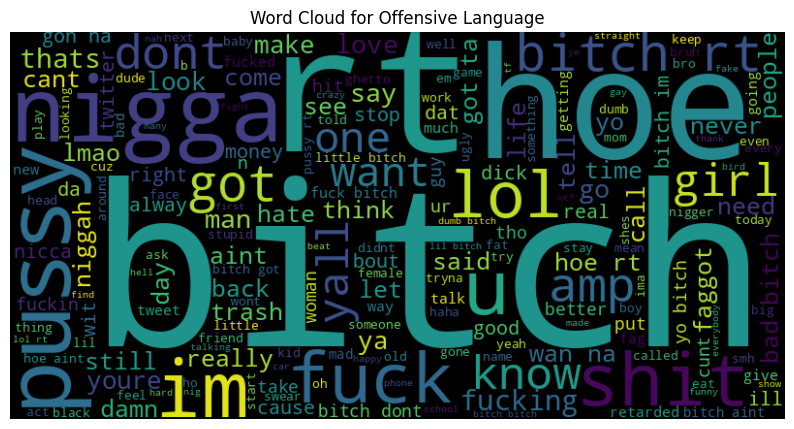

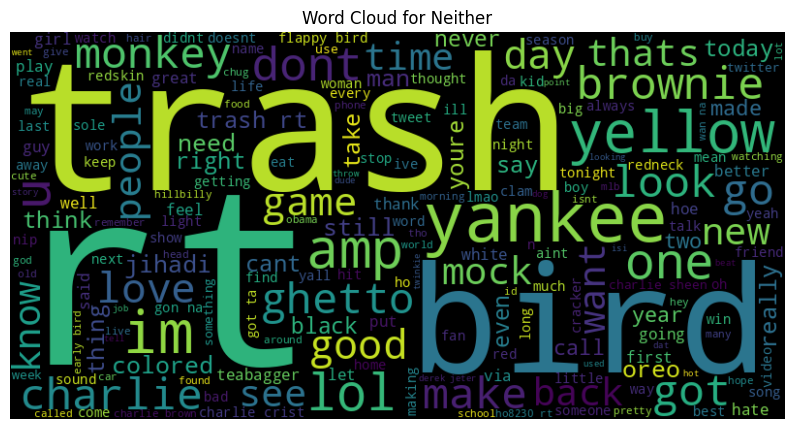

In [21]:
from wordcloud import WordCloud

# Function to plot word cloud
def plot_word_cloud(tokens, title):
    all_words = [word for tweet in tokens for word in tweet]
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(all_words))

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for each class
plot_word_cloud(hate_speech_tokens, 'Word Cloud for Hate Speech')
plot_word_cloud(offensive_language_tokens, 'Word Cloud for Offensive Language')
plot_word_cloud(neither_tokens, 'Word Cloud for Neither')


####4. Modeling

####4.1. Tokenizing

In [22]:
tweet = list(df['tweet'])
labels = list(df['class'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tweet, labels, test_size=0.2, random_state=42)

In [24]:
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

####4.2. Padding

In [25]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [26]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)


In [27]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


####4.3. Evaluation metrics

In [28]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

####4.4. Builing Model

In [29]:
# change dis if u want
output_dim = 200

# Define the model with custom metrics
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile with custom metrics
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', recall, precision, f1])

# Build the model explicitly
model.build(input_shape=(None, max_length))

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 26, 200)             │       6,147,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         168,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,324,299 (24.13 MB)

 Trainable params: 6,324,299 (24.13 MB)

 Non-trainable params: 0 (0.00 B)

####4.4. Training Model

In [30]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.8070 - f1: 0.7468 - loss: 0.5606 - precision: 0.7859 - recall: 0.7198 - val_accuracy: 0.8923 - val_f1: 0.8916 - val_loss: 0.3069 - val_precision: 0.9043 - val_recall: 0.8795
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9283 - f1: 0.9273 - loss: 0.2182 - precision: 0.9366 - recall: 0.9183 - val_accuracy: 0.8866 - val_f1: 0.8879 - val_loss: 0.3166 - val_precision: 0.8940 - val_recall: 0.8819
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.9614 - f1: 0.9613 - loss: 0.1186 - precision: 0.9630 - recall: 0.9597 - val_accuracy: 0.8769 - val_f1: 0.8766 - val_loss: 0.4196 - val_precision: 0.8801 - val_recall: 0.8732
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9793 - f1: 0.9792 - loss: 0.0625 - precision: 0.9797 - recall: 0.9787 - val_accuracy: 0.8788 - val_f1: 0.8796 - val_loss: 0.5301 - val_precision: 0.8811 - val_recall: 0.8780
Epoch 5/10
310/310 ━━━━━━━━━━━━━

####4.5. Loss Curve for Hate Offensive Speech Model

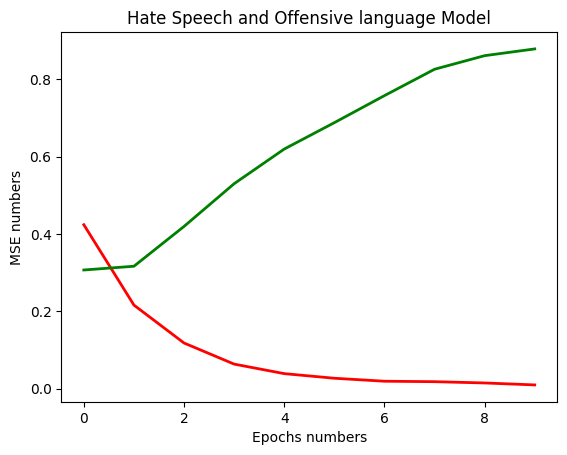

In [31]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()